# PUI Homework 10 
Rachel Lim

# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstile data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.


The data was organized  by Dr. Sina Kashuk at CUSP.
You can get it from the github repo (use the download link to download it live in your notebook). 
It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.dates as mdates
from scipy import stats
import pylab as pl
import statsmodels.api as sm

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/rachellim/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Each time series (per station, per ticket type) contains the number of swipes per week for 194 weeks from 05/21/2010 to 02/21/2014. 

The data are available to you as a *python data cube*. you can load it as 

```
np.load(“MTA_Fare.npy")
```

and you will end up with a python numpy array of 
shape (600, 23, 194)




In [2]:
mtaRides = np.load('MTA_Fare.npy')
#after reading the datacube you should see:
mtaRides.shape


(600, 23, 194)

In [3]:
#mtaRides[194][0][193]

In [4]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

In [5]:
#after that I create a date range (for example with pd.date_range())
date_range = pd.date_range(start='05/21/2010', periods =194, freq='7D')
date_range
#in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
#all time series, each station each ride type, look like this (pretty ugly)

DatetimeIndex(['2010-05-21', '2010-05-28', '2010-06-04', '2010-06-11',
               '2010-06-18', '2010-06-25', '2010-07-02', '2010-07-09',
               '2010-07-16', '2010-07-23',
               ...
               '2013-11-29', '2013-12-06', '2013-12-13', '2013-12-20',
               '2013-12-27', '2014-01-03', '2014-01-10', '2014-01-17',
               '2014-01-24', '2014-01-31'],
              dtype='datetime64[ns]', length=194, freq='7D')

In [6]:
#summing on axis 0 returns the total number of swipes per card per week
np.nansum(mtaRides,axis=0).shape

(23, 194)

In [7]:
#summing on axis 1 returns the total number of swipes per station type per week
np.nansum(mtaRides,axis=1).shape

(600, 194)

In [8]:
#summing on axis 2 returns the total number of swipes per station per card type for all weeks
np.nansum(mtaRides,axis=2).shape

(600, 23)

## Task 1: 
### Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
### Identify it, figure out the date (you know when the data starts and what the cadence is) and figure out what it is due to.

In [9]:
count_cardtype = np.nansum(mtaRides, axis=0)
count_station = np.nansum(mtaRides, axis=1)

In [10]:
#sum across all stations for event detection 
allStations = np.nansum(count_station, axis=0)
allStations.shape

(194,)

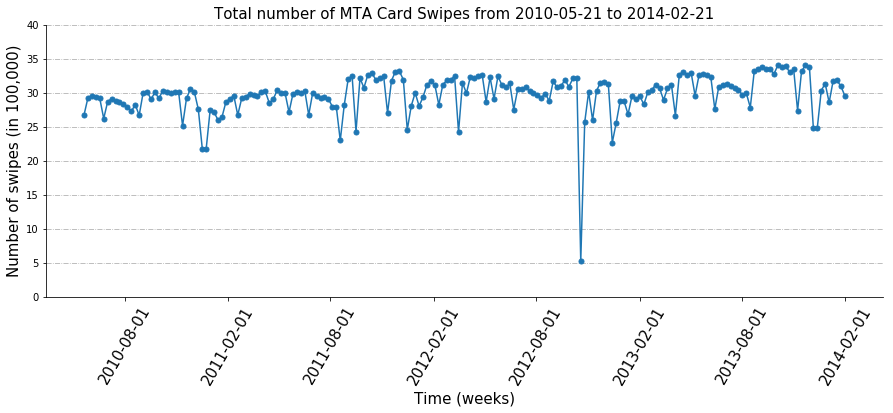

In [11]:
fig = pl.figure(figsize=(15,5))
ax = fig.add_subplot(111)

ax.plot(date_range, allStations/1e6, '.-', ms=10)

ax.set_xlabel("Time (weeks)", fontsize=15)
ax.set_ylabel("Number of swipes (in 100,000)", fontsize=15)

ax.set_xticklabels(date_range, rotation=60, fontsize=15)

ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

ax.set_ylim([0,40])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title("Total number of MTA Card Swipes from 2010-05-21 to 2014-02-21", fontsize=15)

ax.grid(axis='y', linestyle='-.');

Figure 1: Total Number of MTA Card Swipes from 05/21/2010 to 02/21/2014.¶

In [12]:
popMean = np.nanmean(allStations)
popStd = np.nanstd(allStations)

print("Mean: {:.4f}".format(popMean))
print("Standard Deviation: {:.4f}".format(popStd))

Mean: 29778001.6082
Standard Deviation: 2984034.3478


In [13]:
thresholds = [popMean + 3 * popStd, 
              popMean - 3 * popStd]
print("3-sigma thresholds: {}".format(thresholds))

3-sigma thresholds: [38730104.651779145, 20825898.564715698]


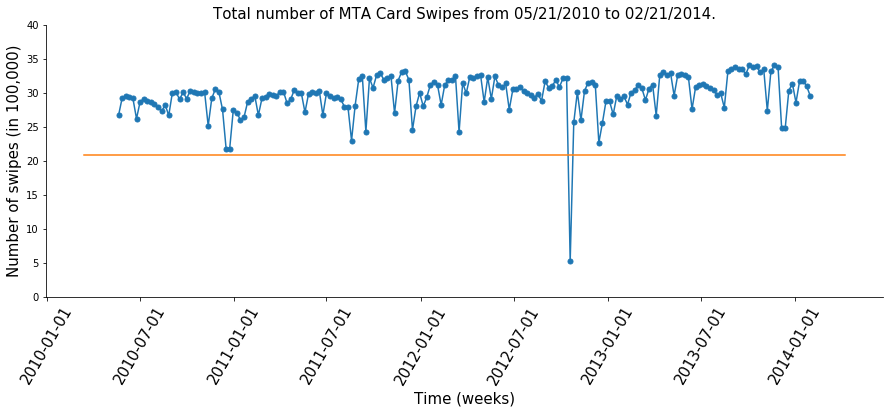

In [14]:
fig = pl.figure(figsize=(15,5))
ax = fig.add_subplot(111)

ax.plot(date_range, allStations/1e6, '.-', ms=10)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [thresholds[1]/1e6, thresholds[1]/1e6]);

ax.set_xlabel("Time (weeks)", fontsize=15)
ax.set_ylabel("Number of swipes (in 100,000)", fontsize=15)

ax.set_xticklabels(date_range, rotation=60, fontsize=15)

ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

ax.set_ylim([0,40])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title("Total number of MTA Card Swipes from 05/21/2010 to 02/21/2014.", fontsize=15)

Figure 2: Total number of MTA card swipes from 05/21/2010 to 02/21/2014, with a threshold set at 3-sigma

In [15]:
#identify the week experiencing the drop in ridership (week with least ridership)
np.amin(allStations)
np.argmin(allStations)

126

In [16]:
date_range[126]

Timestamp('2012-10-19 00:00:00', freq='7D')

Event detection: The most prominent event can be identified as a significant drop (>3-sigma) in figure 2, occuring around the period between October 19 and October 26, 2012. This is likely to be due to Hurricane Sandy which led to the sharp decline in ridership. 

## Task 2: 
### Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)


how well can you fit a line to this? stable/ peak? good line fit 


In [17]:
count_cardtype = np.nansum(mtaRides, axis=0)

In [18]:
count_cardtype = pd.DataFrame(count_cardtype.T)
count_cardtype.set_index(date_range, inplace=True)
count_cardtype.columns = ridetype
count_cardtype.head()


,10t,14d,1d,2t,30d,7d,ada,afas,exp,ez,...,month,rfm,rr,sen,spec,tcmc,t,umlim,xbus,stud
2010-05-21,11494477,530386,47663,186413,46670,3697305,8551799,9925,333059,511894,...,122996,789972,59671,28083,-138,124555,20922,5990,220,-600
2010-05-28,12526720,583394,51347,199090,64214,3981669,9486255,11708,282616,577884,...,151809,907929,69070,32194,-139,121574,21531,5981,335,-600
2010-06-04,12766490,586057,51499,199531,56857,4032893,9476401,12140,301891,615400,...,151401,913987,69437,32481,-137,122044,21296,6353,328,-600
2010-06-11,12653538,562465,51926,196252,37292,4032616,9449944,11084,305376,606133,...,146957,902412,67962,32267,-137,121914,21493,6453,347,-600
2010-06-18,12809558,548722,51017,194747,35074,3925310,9293866,10379,335644,563310,...,137752,855437,66241,31797,40,119640,20161,6177,316,-600


In [19]:
ridetype_dict = {i:ridetype[i] for i in range(len(ridetype))}
ridetype_dict;

cardtype_rmean = count_cardtype.rolling(center=False, axis=0, window=10).mean()
cardtype_rstd = count_cardtype.rolling(center=False, axis=0, window=10).std()

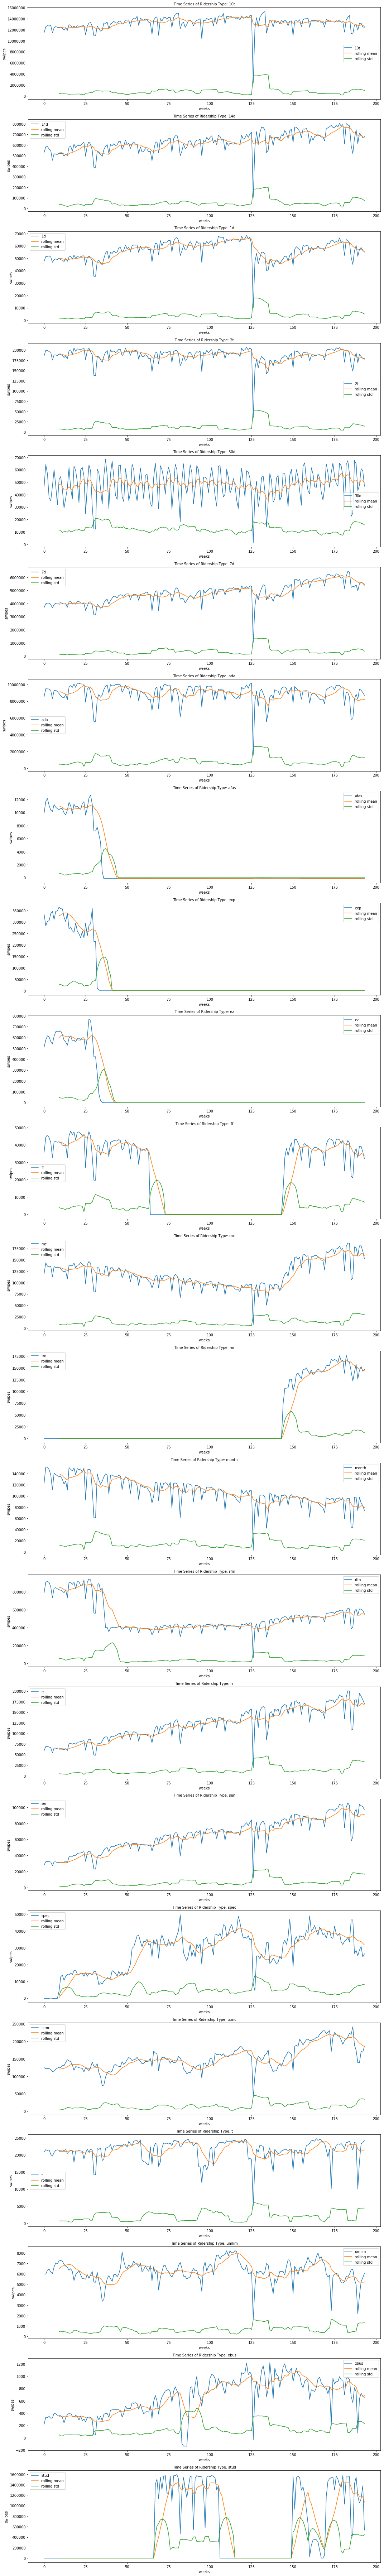

In [20]:
fig = plt.figure(figsize=(15,100))
result = {}
columns = count_cardtype.columns
for i in range(len(columns)):
#rolling mean, window 10
    ax = fig.add_subplot(23,1,i+1)
    ax.plot(np.arange(len(count_cardtype.iloc[:,i])), count_cardtype.iloc[:,i], label=columns[i])
    ax.plot(np.arange(len(count_cardtype.iloc[:,i])), cardtype_rmean.iloc[:,i], label="rolling mean")
    ax.plot(np.arange(len(count_cardtype.iloc[:,i])), cardtype_rstd.iloc[:,i], label="rolling std")
    ax.get_xaxis().get_major_formatter().set_scientific(False)
    ax.get_yaxis().get_major_formatter().set_scientific(False)
    ax.set_xlabel('weeks')
    ax.set_ylabel('swipes')
    ax.set_title("Time Series of Ridership Type: {}".format(ridetype_dict[i]), fontsize=10)
    plt.legend(fontsize=10)
plt.tight_layout()

In [21]:
for i in ridetype:
    rollingmean = pd.rolling_mean(count_cardtype[i],10)
    rollingmean.dropna(inplace=True)
    ratio = rollingmean.head(10).sum()/rollingmean.tail(10).sum()
    print ("Card type: {},ratio of first 10 weeks to final 10 weeks: {:.2f}".format(i, ratio))

Card type: 10t,ratio of first 10 weeks to final 10 weeks: 0.95
Card type: 14d,ratio of first 10 weeks to final 10 weeks: 0.74
Card type: 1d,ratio of first 10 weeks to final 10 weeks: 0.85
Card type: 2t,ratio of first 10 weeks to final 10 weeks: 1.02
Card type: 30d,ratio of first 10 weeks to final 10 weeks: 0.89
Card type: 7d,ratio of first 10 weeks to final 10 weeks: 0.69
Card type: ada,ratio of first 10 weeks to final 10 weeks: 1.07
Card type: afas,ratio of first 10 weeks to final 10 weeks: -78.55
Card type: exp,ratio of first 10 weeks to final 10 weeks: -2463.60
Card type: ez,ratio of first 10 weeks to final 10 weeks: -4469.11
Card type: ff,ratio of first 10 weeks to final 10 weeks: 1.15
Card type: mc,ratio of first 10 weeks to final 10 weeks: 0.80
Card type: mr,ratio of first 10 weeks to final 10 weeks: -0.00
Card type: month,ratio of first 10 weeks to final 10 weeks: 1.62
Card type: rfm,ratio of first 10 weeks to final 10 weeks: 1.51
Card type: rr,ratio of first 10 weeks to final 1

/Users/rachellim/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
  


Ridership types that steadily increased in ridership are: rr and sen
 
Ridership types that steadily decreased in ridership are: month

## Task 3:
### Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)


In [22]:
count_station = np.nansum(mtaRides, axis=1)
count_station.shape

(600, 194)

In [23]:
count_station =pd.DataFrame(count_station).T
count_station.head()

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,126877,37305,6605,16377,18563,19986,12448,11090,10481,147186,...,-23,-23,-23,-23,-23,-23,-23,-23,-23,-23
1,149476,46463,6880,17407,19902,20624,13643,11658,11029,154825,...,-23,-23,-23,-23,-23,-23,-23,-23,-23,-23
2,152382,49358,7228,17594,19947,21224,13718,12036,10880,155957,...,-23,-23,-23,-23,-23,-23,-23,-23,-23,-23
3,160174,44848,5730,14241,16075,17411,11459,9808,9122,154913,...,-23,-23,-23,-23,-23,-23,-23,-23,-23,-23
4,162640,41508,7031,17588,20282,20908,14093,11943,10922,157627,...,-23,-23,-23,-23,-23,-23,-23,-23,-23,-23


In [24]:
N = len(count_station)
N

194

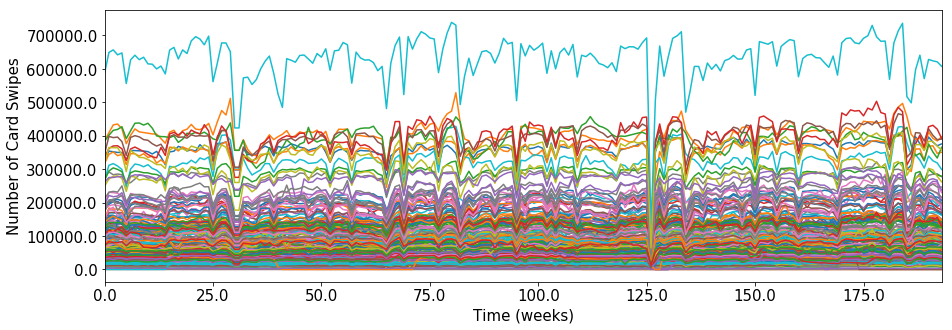

In [25]:
fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)
for i in range(N):
    ax = count_station[i].plot()
ax.set_xticklabels(ax.get_xticks(), fontsize=15)
ax.set_yticklabels(ax.get_yticks(), fontsize=15)
plt.xlabel("Time (weeks)", fontsize=15)
plt.ylabel("Number of Card Swipes", fontsize=15);

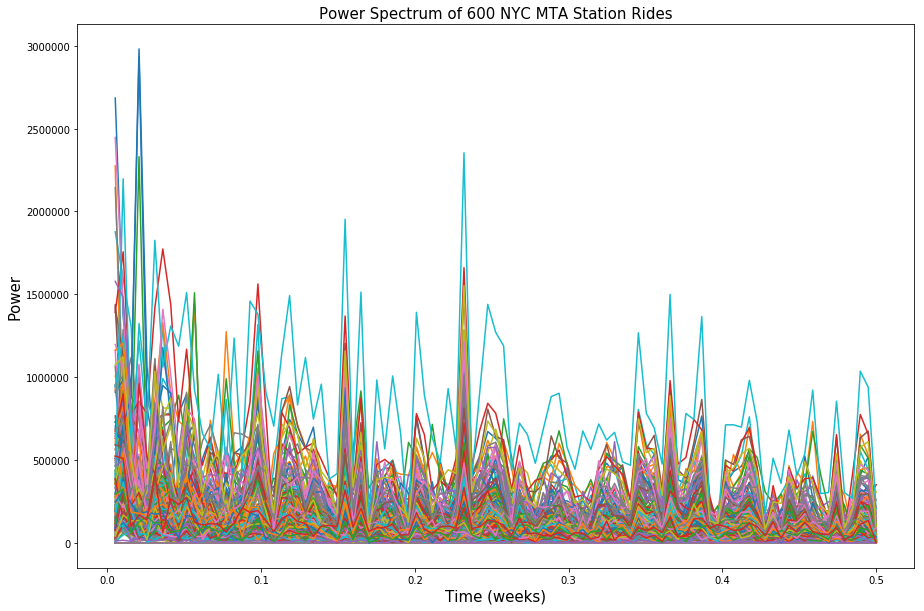

In [26]:
allperiods = [1./194, 1./104, 1./52, 1./26, 1./13, 1./8, 1./4, 1./2]
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)

for i in range(N):
    f = np.abs(np.fft.rfft(count_station[i]))
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[1:]), '-')
ax.set_xlabel('Time (weeks)', fontsize=15)
ax.set_ylabel('Power', fontsize=15)
ax.set_title('Power Spectrum of 600 NYC MTA Station Rides', fontsize=15)

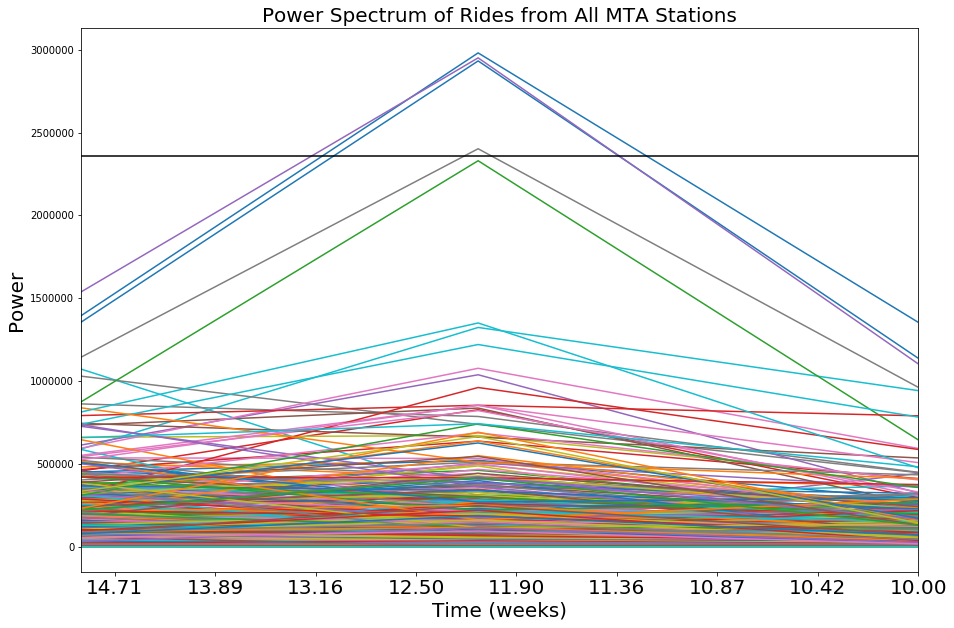

In [32]:
fig=pl.figure(figsize=(15,10))
ax=fig.add_subplot(111)
peak = []
for i in count_station.keys():
    f = np.abs(np.fft.rfft(count_station[i]))
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[1:]), '-')
    if f[4] > 2.36e6:
        peak.append(i)
ax.plot((1./60, 1./40), (2.36e6, 2.36e6), 'k-')
ax.set_xlim(1./60, 1./40)
ax.set_xticklabels([ "%.2f"%(1/4./f) for f in ax.get_xticks()], fontsize=20)
pl.xlabel("Time (weeks)", fontsize=20)
pl.ylabel("Power", fontsize=20)
pl.title("Power Spectrum of Rides from All MTA Stations", fontsize=20)

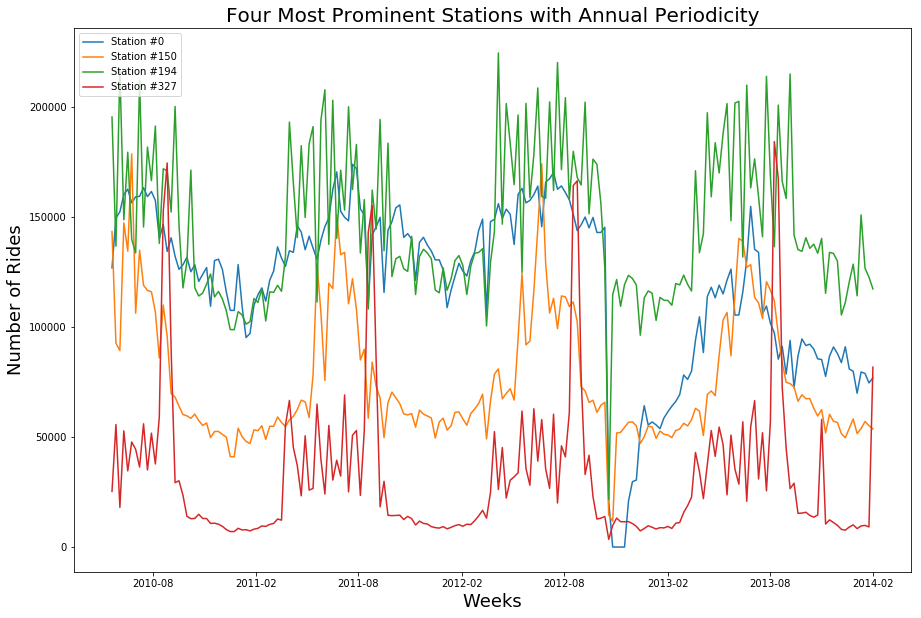

In [36]:
plt.figure(figsize=(15,10))
for i in peak:
    plt.plot(date_range, count_station[i], label='Station #%s'%i)
plt.xlabel('Weeks', fontsize=18)
plt.ylabel('Number of Rides', fontsize=18)
plt.title('Four Most Prominent Stations with Annual Periodicity', fontsize=20)
plt.legend(loc = 2)

In [34]:
peak

[0, 150, 194, 327]

The four stations that show the most prominent periodic trend on an annual period are : 0, 150, 194 and 327. 

## EXTRA CREDIT: Cluster. 
### Cluster the time series, i.e. identify groups of time series that look similar among each other. You can use KMeans for example to identify common trends, or PCA (Principle Component Analysis). 
### Since this is extra credit I will leave it to you to figure out the details, but for KMeans for e.g. if you use the sklearn.cluster package it would look something like:

when applying machine learning techniques, we want to standardise data to remove covariance. with a table of observations, and features, we want features that are inherently independent to each other. standardise each columns. subtract mean and divide by std. (mean 0 and std 1). Bur for time series, features are not independent, we want to udnerstand if there are relationships. by standardising each day of the week, we lose relatiionship between days of week. instad, we normalise by rows of observations and not features. (mean/std per row). 

i am flattening the first 2 dimensions of the cube to cluster all light curves for all stations and all types

```
tots = data.transpose(2,0,1).reshape(data.shape[2], data.shape[1]*data.shape[0]).T
```

removing empty light curves

```
tots = tots[tots.std(1)>0]
```

with Kmeans you have to choose the number of clusters ahead km = 

```
KMeans(n_clusters=10)
```

and standardize the lightcurves before clustering. Notice: standardize, not whiten! If you have done clustering before you may have whitened the data: removed the variance by "column", here you want to remove the variance by "row". We will discuss this in the clustering lecture. 
```
vals = ((tots.T - tots.mean(1))/tots.std(1)).T
```

then you can run:

```
km.fit(vals)
```


for ticket type take mean across stations. 
600 weeks, 23 ticket types, 194.. 
take average across stations 
ticket types if asking for subway periodicity. 

In [54]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [55]:
tots = mtaRides.transpose(2,0,1).reshape(mtaRides.shape[2], mtaRides.shape[1]*mtaRides.shape[0]).T

In [56]:
tots = tots[tots.std(1)>0]
tots.shape

(9317, 194)

In [57]:
vals = ((tots.T - tots.mean(1))/tots.std(1)).T

In [58]:
from sklearn.cluster import KMeans


[ 58.46553601  21.88409317  10.6935882    8.51117263   7.62273904
   4.55593829   3.65253831   2.73172804   2.00559124   1.85647838
   1.61890821   1.48541325   1.30998363   1.19217759   1.04426185
   0.9996843    0.95499457   0.87232963   0.84023075   0.79863123
   0.74624778   0.72854793   0.67806022   0.66186076   0.62672602
   0.60959521   0.59684307   0.58058369   0.57275579   0.54189761
   0.52610361   0.51255533   0.47204383   0.45280312   0.44357275
   0.42684723   0.41917899   0.39907835   0.39716094   0.38603326
   0.36700215   0.35013386   0.34403953   0.33663365   0.32472955
   0.32007202   0.30769749   0.29834374   0.28955525   0.28563637]


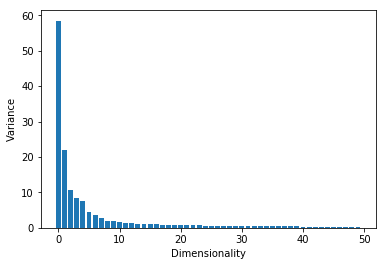

In [62]:
from sklearn.decomposition import PCA
n=50
pca = PCA(n)
Xproj = pca.fit_transform(vals)
eigenvalues = pca.explained_variance_
print(pca.explained_variance_)
plt.bar(np.arange(n), eigenvalues);
plt.xlabel("Dimensionality")
plt.ylabel("Variance")
plt.show()

In [71]:
n=10
km = KMeans(n_clusters=n, random_state=3425)
res=km.fit(Xproj)
res.labels_

array([8, 8, 8, ..., 6, 1, 6], dtype=int32)

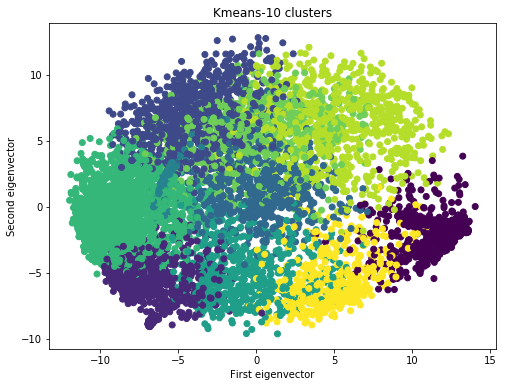

In [75]:
plt.figure(2, figsize=(8, 6))
plt.clf()
# Plot the training points
plt.scatter(Xproj[:, 0], Xproj[:, 1], c=res.labels_)
plt.xlabel('First eigenvector')
plt.ylabel('Second eigenvector')
plt.title("Kmeans-{} clusters".format(n))
plt.show()